## Задание 5 и 6 — Анализ выбросов. Результаты и гипотезы.

### Цель
- Провести анализ выбросов по IQR
- Показать влияние (до/после) и аргументировать стратегию
- Выявить, что важно для выживаемости, какие проблемы были в данных, какие решения приняли
- Сформулировать гипотезы для моделирования.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Фиксируем random_state для воспроизводимости результатов
np.random.seed(42)

# Загрузка данных
FILE_PATH = "../data/interim/diabetes_stage4.csv"
df = pd.read_csv(FILE_PATH)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.133413,0.314928,0.234415,0.483333,1
1,0.058824,0.264516,0.428571,0.239130,0.133413,0.171779,0.116567,0.166667,0
2,0.470588,0.896774,0.408163,0.239130,0.133413,0.104294,0.253629,0.183333,1
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.367742,0.530612,0.445652,0.199519,0.300613,0.039710,0.700000,0
764,0.117647,0.503226,0.469388,0.217391,0.133413,0.380368,0.111870,0.100000,0
765,0.294118,0.496774,0.489796,0.173913,0.117788,0.163599,0.071307,0.150000,0
766,0.058824,0.529032,0.367347,0.239130,0.133413,0.243354,0.115713,0.433333,1


# АНАЛИЗ ВЫБРОСОВ ПО IQR

In [2]:
outliers_info = {}  # информация для каждого столбца

for column in df.columns[:-1]:  # исключаем целевую переменную Outcome
    # Сортировка данных
    sorted_data = np.sort(df[column])
    
    # Квартили
    Q1 = np.percentile(df[column], 25)
    Q3 = np.percentile(df[column], 75)
    
    # Межквартильный размах
    IQR = Q3 - Q1
    
    # Границы "усов"
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Выбросы
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outliers_count = len(outliers)
    
    outliers_info[column] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers_count': outliers_count,
        'outliers_percentage': (outliers_count / len(df)) * 100
    }
    
    print(f"\n{column}:")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Границы: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Выбросы: {outliers_count} ({outliers_info[column]['outliers_percentage']:.2f}%)")


Pregnancies:
  Q1: 0.06, Q3: 0.35, IQR: 0.29
  Границы: [-0.38, 0.79]
  Выбросы: 4 (0.52%)

Glucose:
  Q1: 0.36, Q3: 0.62, IQR: 0.26
  Границы: [-0.03, 1.01]
  Выбросы: 0 (0.00%)

BloodPressure:
  Q1: 0.41, Q3: 0.57, IQR: 0.16
  Границы: [0.16, 0.82]
  Выбросы: 14 (1.82%)

SkinThickness:
  Q1: 0.20, Q3: 0.27, IQR: 0.08
  Границы: [0.08, 0.39]
  Выбросы: 87 (11.33%)

Insulin:
  Q1: 0.13, Q3: 0.14, IQR: 0.01
  Границы: [0.12, 0.15]
  Выбросы: 346 (45.05%)

BMI:
  Q1: 0.19, Q3: 0.38, IQR: 0.19
  Границы: [-0.09, 0.66]
  Выбросы: 8 (1.04%)

DiabetesPedigreeFunction:
  Q1: 0.07, Q3: 0.23, IQR: 0.16
  Границы: [-0.17, 0.48]
  Выбросы: 29 (3.78%)

Age:
  Q1: 0.05, Q3: 0.33, IQR: 0.28
  Границы: [-0.38, 0.76]
  Выбросы: 9 (1.17%)


# Визуализация выбросов до обработки

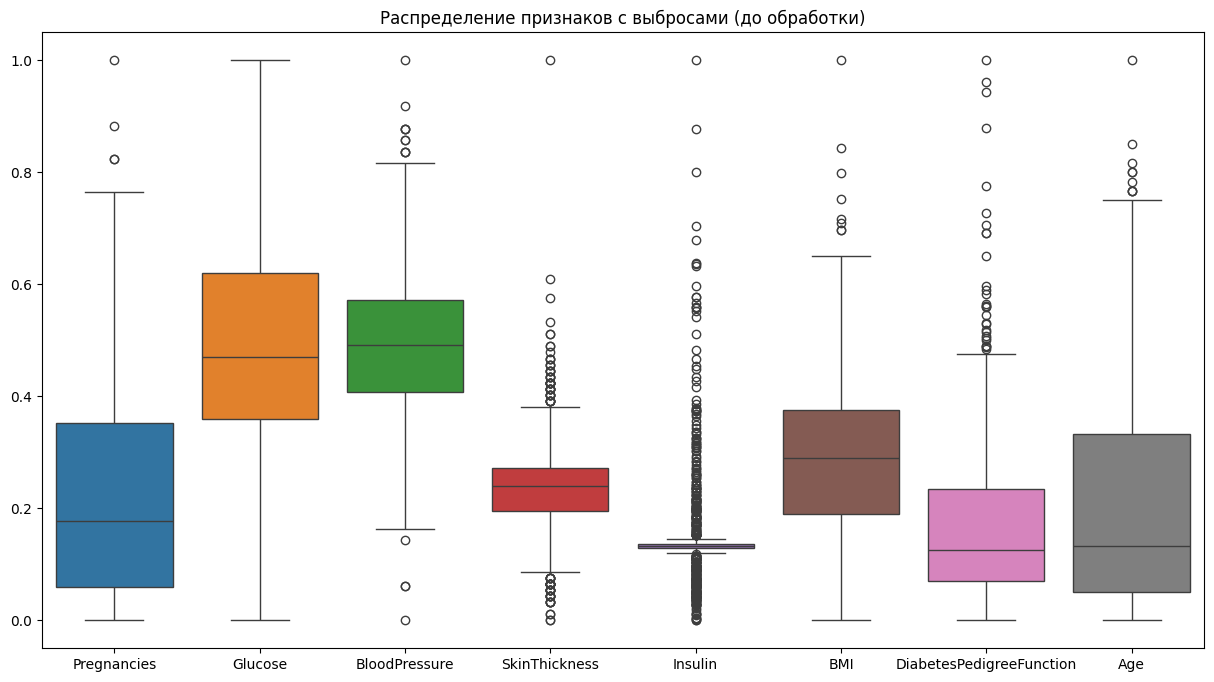

In [3]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=df.drop('Outcome', axis=1))
plt.title('Распределение признаков с выбросами (до обработки)')
plt.show()

# Стратегия обработки выбросов
- Мы не будем удалять выбросы, так как в медицинских данных они могут представлять собой важные клинические случаи.
- Вместо этого используем метод винсоризации (ограничение выбросов)

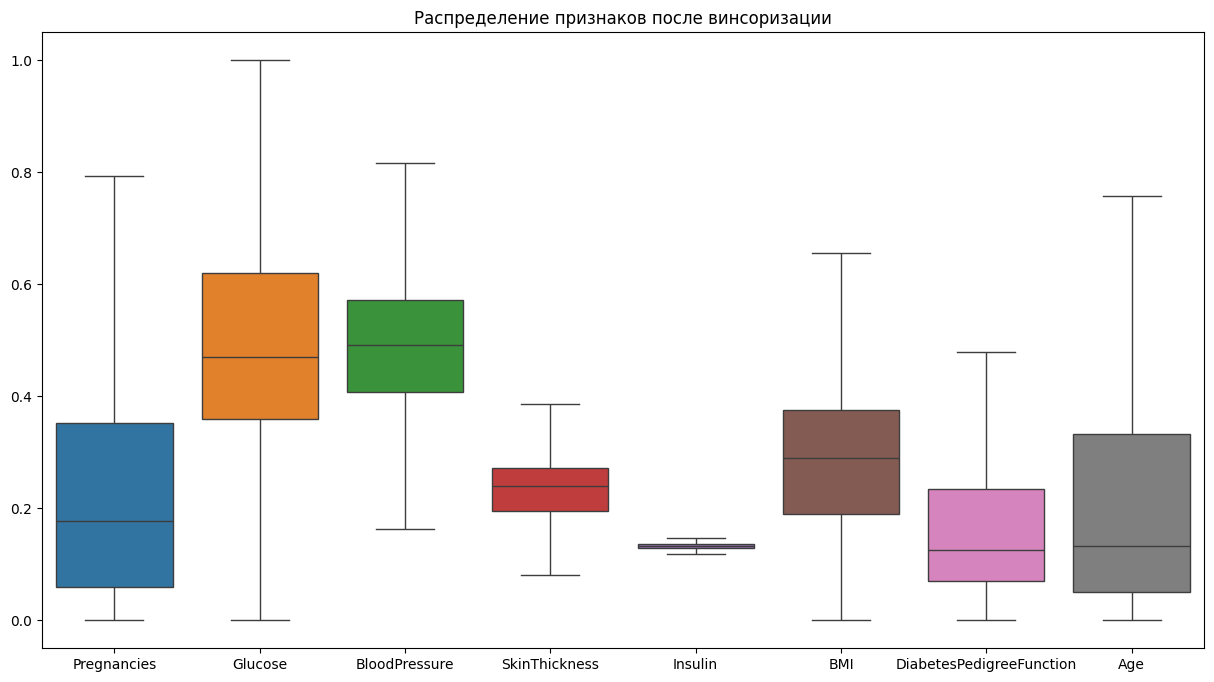

In [7]:
df_winsorized = df.copy()
for column in df.columns[:-1]:
    lower = outliers_info[column]['lower_bound']
    upper = outliers_info[column]['upper_bound']
    df_winsorized[column] = np.clip(df_winsorized[column], lower, upper)

# Визуализация после winsorization
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_winsorized.drop(columns=['Outcome']))
plt.title('Распределение признаков после винсоризации')
plt.show()

# РЕЗУЛЬТАТЫ АНАЛИЗА И ГИПОТЕЗЫ

## Проблемы в данных и решения:
1. - Проблема: Наличие выбросов в медицинских показателях
   - Решение: Винсоризация выбросов.
2. - Проблема: Сильный дисбаланс в количестве пропусков между признаками
   - Решение: Замена пропусков медианой для SkinThickness и Insulin и средним значением для Glucose, BloodPressure, BMI.

## Гипотезы для моделирования:
1. Возраст является важным фактором риска развития диабета.
2. Комбинация высоких значений глюкозы и индекса массы тела у пациента значительно повышает риск диабета.

## Ключевые выводы:
1. Выполнено исследование качества данных:
- Выявлены и обработаны скрытые пропуски
- Проведен анализ распределений всех переменных
- Обнаружен дисбаланс классов (65% без диабета и 35% с диабетом)
- Выполнен статистический анализ выбросов методом IQR
2. Проведено исследование взаимосвязей:
- Применены статистические тесты для анализа значимости признаков
- Построена корреляционная матрица для выявления взаимосвязей (уровень глюкозы наиболее важный предиктор диабета)
3. Осуществлена предобработка данных:
- Импутация пропусков с использованием медианы и среднего
- Масштабирование признаков
- Обработка выбросов методом винсоризации

# Ключевые графики:
## До нормализации:
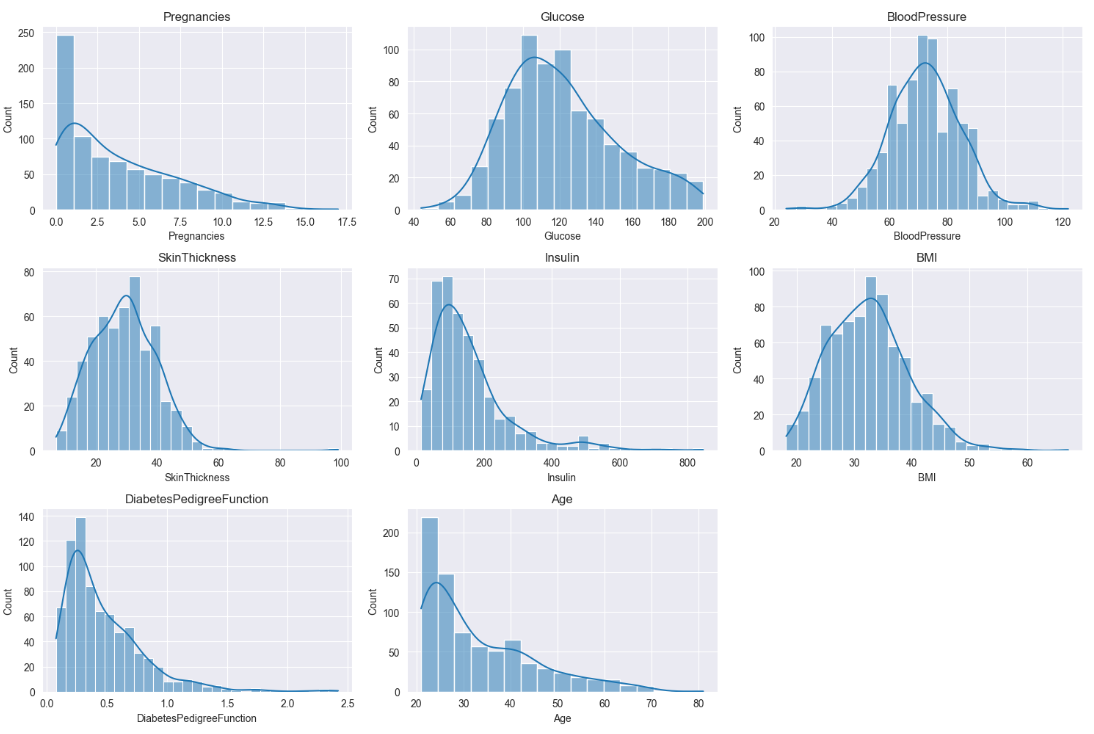
## После нормализации:
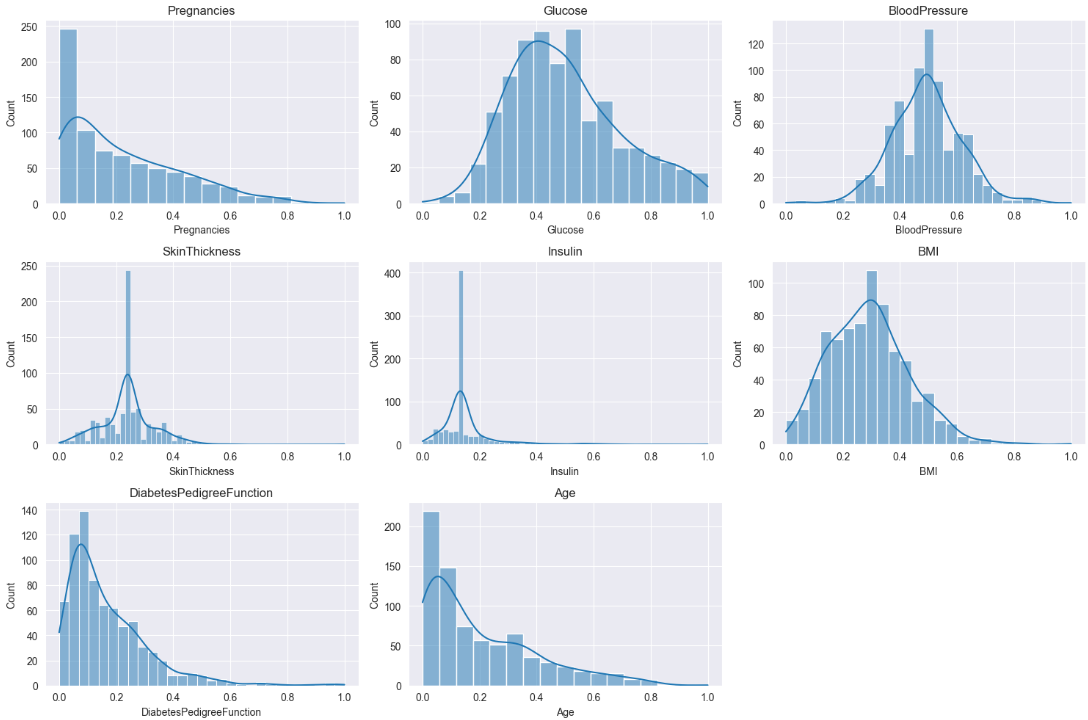
## Распределение классов:
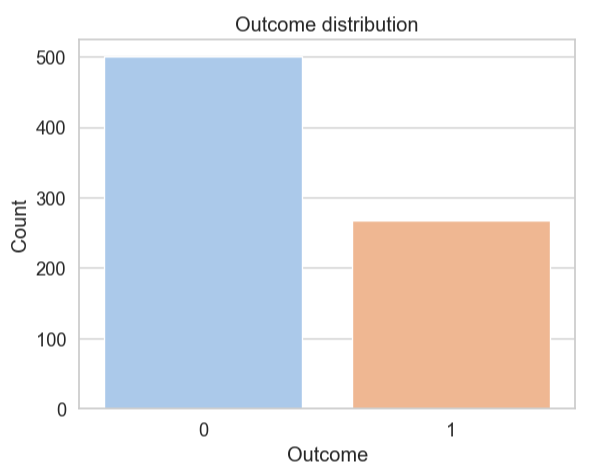
## Распределение выбросов:
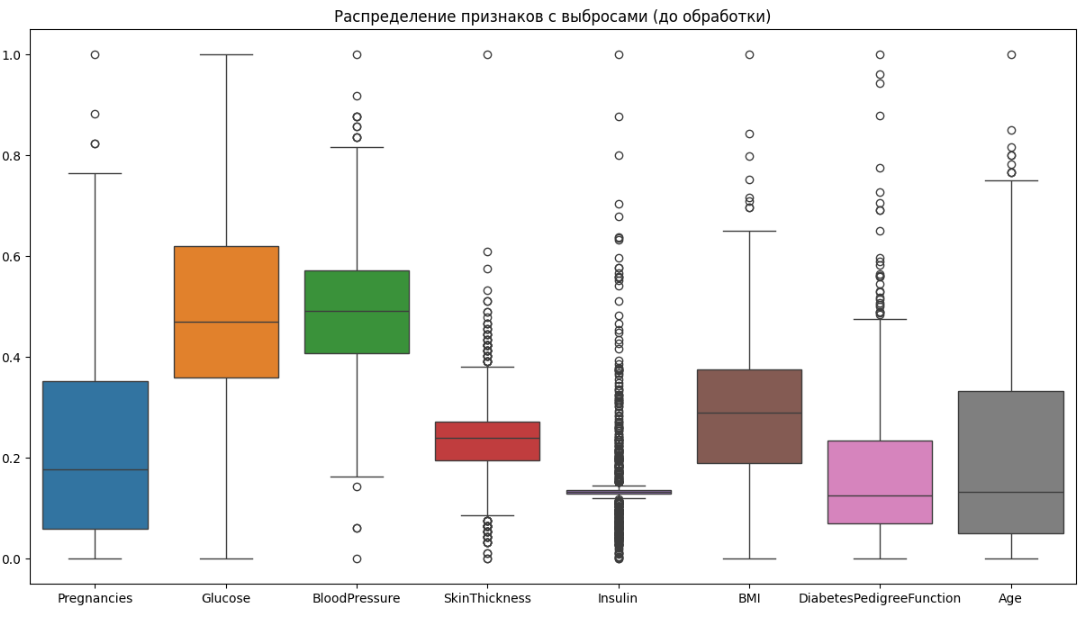
## Корреляционная матрица
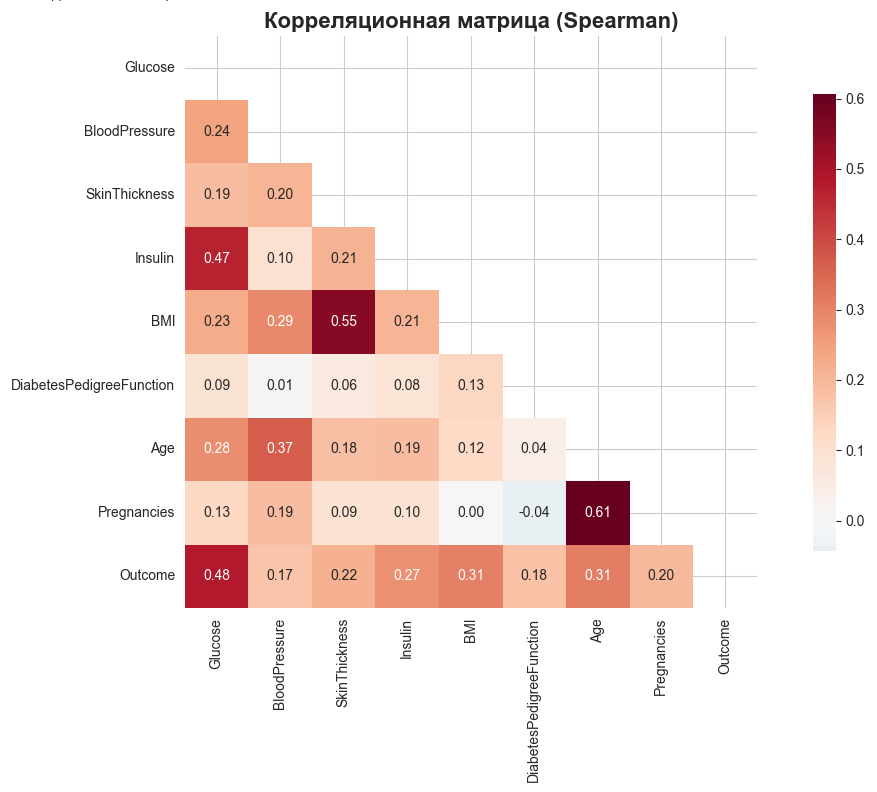

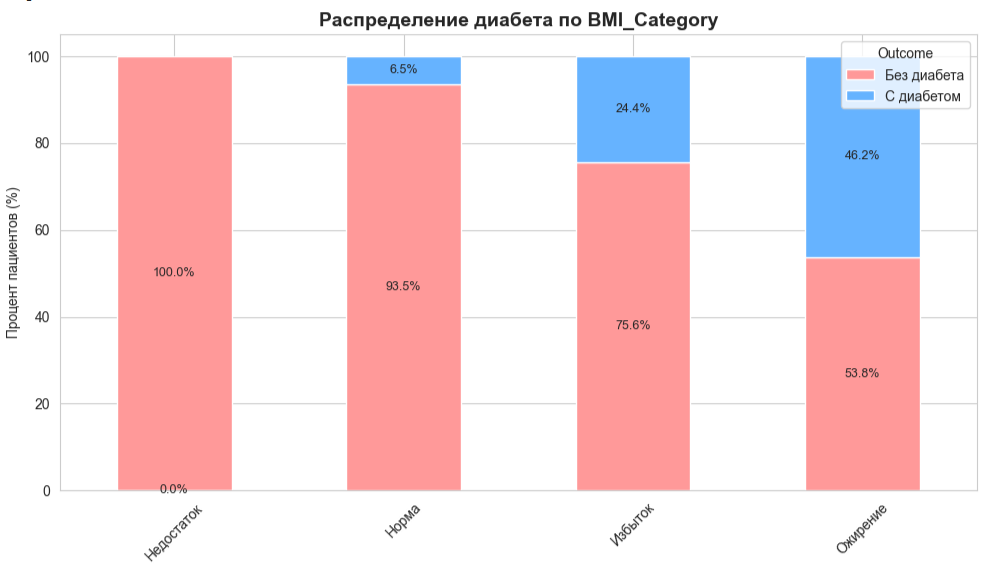
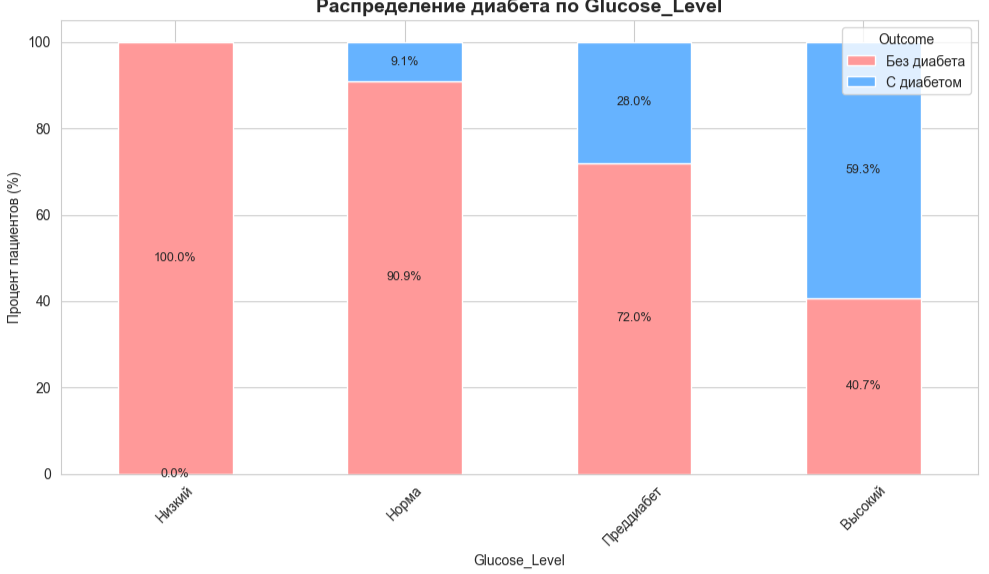

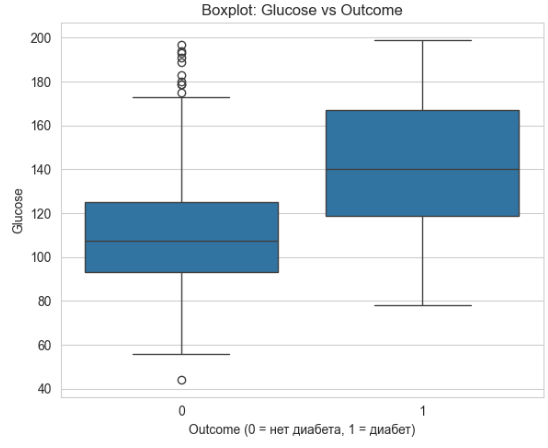
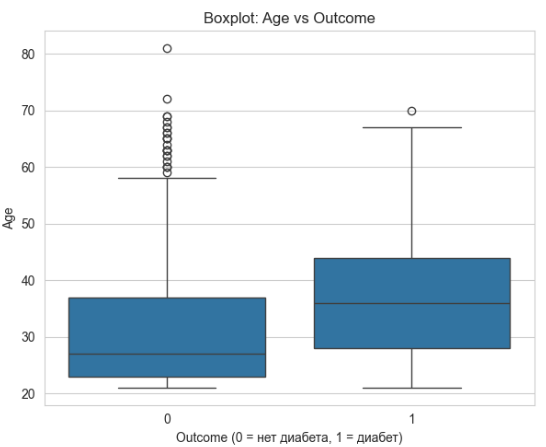

In [8]:
print("Версии библиотек:")
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")

Версии библиотек:
Pandas: 2.3.3
Numpy: 2.3.3
Matplotlib: 3.10.6
Seaborn: 0.13.2
